In [1]:
%load_ext autotime

from gscore.parsers.sqlite_file import SQLiteFile

time: 631 µs (started: 2022-02-04 13:56:57 +01:00)


In [2]:
sqmass_file_path = "/home/aaron/projects/ghost/data/spike_in/chromatograms/AAS_P2009_167.sqMass"
osw_file_path = "/home/aaron/projects/ghost/data/spike_in/openswath/AAS_P2009_167.osw"

time: 796 µs (started: 2022-02-04 13:56:58 +01:00)


In [3]:
from gscore.parsers import queries

time: 1.4 ms (started: 2022-02-04 13:56:59 +01:00)


In [4]:
from gscore.parsers import osw

time: 1.02 s (started: 2022-02-04 13:57:01 +01:00)


In [5]:
osw_file = osw.OSWFile(
    osw_file_path,
    set_indices=True
)

time: 1.31 ms (started: 2022-02-04 13:57:02 +01:00)


In [6]:
precursors = osw_file.parse_to_precursors(
    query=queries.SelectPeakGroups.FETCH_PREC_RECORDS
)

time: 3.15 s (started: 2022-02-04 13:57:05 +01:00)


In [7]:
precursors

time: 6.12 ms (started: 2022-02-04 13:57:10 +01:00)


In [8]:
from gscore.parsers import sqmass

time: 70.1 ms (started: 2022-02-04 13:57:10 +01:00)


In [9]:
sqmass_file = sqmass.SqMassFile(sqmass_file_path)

time: 357 µs (started: 2022-02-04 13:57:11 +01:00)


In [10]:
chromatograms = sqmass_file.parse()

time: 14.8 s (started: 2022-02-04 13:57:13 +01:00)


In [11]:
%load_ext Cython

time: 313 ms (started: 2022-02-04 13:57:28 +01:00)


In [12]:
from gscore.chromatograms import Chromatograms, Chromatogram
import numpy as np

def set_chromatograms(precursors, chromatograms):

    for precursor in precursors:

        precursor_chromatograms = chromatograms.get(
            f"{precursor.mz}_{precursor.charge}",
            precursor.unmodified_sequence
        )

        if precursor_chromatograms:

            for peakgroup in precursor.peakgroups:

                peakgroup_chromatograms = dict()

                start_rt = peakgroup.start_rt
                end_rt = peakgroup.end_rt

                new_rt_steps = np.linspace(
                    start_rt,
                    end_rt,
                    25
                )

                for key, chrom in precursor_chromatograms.items():

                    peakgroup_chromatogram = Chromatogram(
                        type="peakgroup",
                        chrom_id=key,
                        precursor_mz=peakgroup.mz,
                        intensities=chrom.interpolated_chromatogram(new_rt_steps),
                        rts=new_rt_steps,
                        start_rt=peakgroup.start_rt,
                        end_rt=peakgroup.end_rt
                    )

                    peakgroup_chromatograms[key] = peakgroup_chromatogram

                    peakgroup.chromatograms = peakgroup_chromatograms
    return precursors

time: 690 µs (started: 2022-02-04 13:57:28 +01:00)


In [13]:
precursors = set_chromatograms(
    precursors,
    chromatograms
)

time: 15.2 s (started: 2022-02-04 13:57:28 +01:00)


In [14]:
for precursor in precursors:

    break

time: 208 µs (started: 2022-02-04 13:57:44 +01:00)


In [15]:
precursor.peakgroups.sort(key=lambda x: x.probability, reverse=True)

peakgroup = precursor.peakgroups[0]

time: 631 µs (started: 2022-02-04 13:57:44 +01:00)


In [18]:
peakgroup.probability

0.9712142134907232

time: 2.26 ms (started: 2022-02-04 13:57:59 +01:00)


In [19]:
interpolated_chromatograms = peakgroup.get_chromatogram_intensity_arrays(
    use_relative_intensities=True
)

time: 1.53 ms (started: 2022-02-04 13:57:59 +01:00)


In [20]:
import seaborn as sns

time: 15.8 ms (started: 2022-02-04 13:58:01 +01:00)


In [21]:
import pandas as pd

chrom_df = pd.DataFrame(
    interpolated_chromatograms.T
).reset_index()

time: 1.74 ms (started: 2022-02-04 13:58:01 +01:00)


In [22]:
melted_chroms = pd.melt(
    chrom_df,
    id_vars=["index"]
)
melted_chroms

,index,variable,value
0,0,0,0.000443
1,1,0,0.023063
2,2,0,0.045684
3,3,0,0.031547
4,4,0,0.008261
...,...,...,...
145,20,5,0.298156
146,21,5,0.214433
147,22,5,0.149154
148,23,5,0.152667


time: 8.82 ms (started: 2022-02-04 13:58:01 +01:00)


<AxesSubplot:>

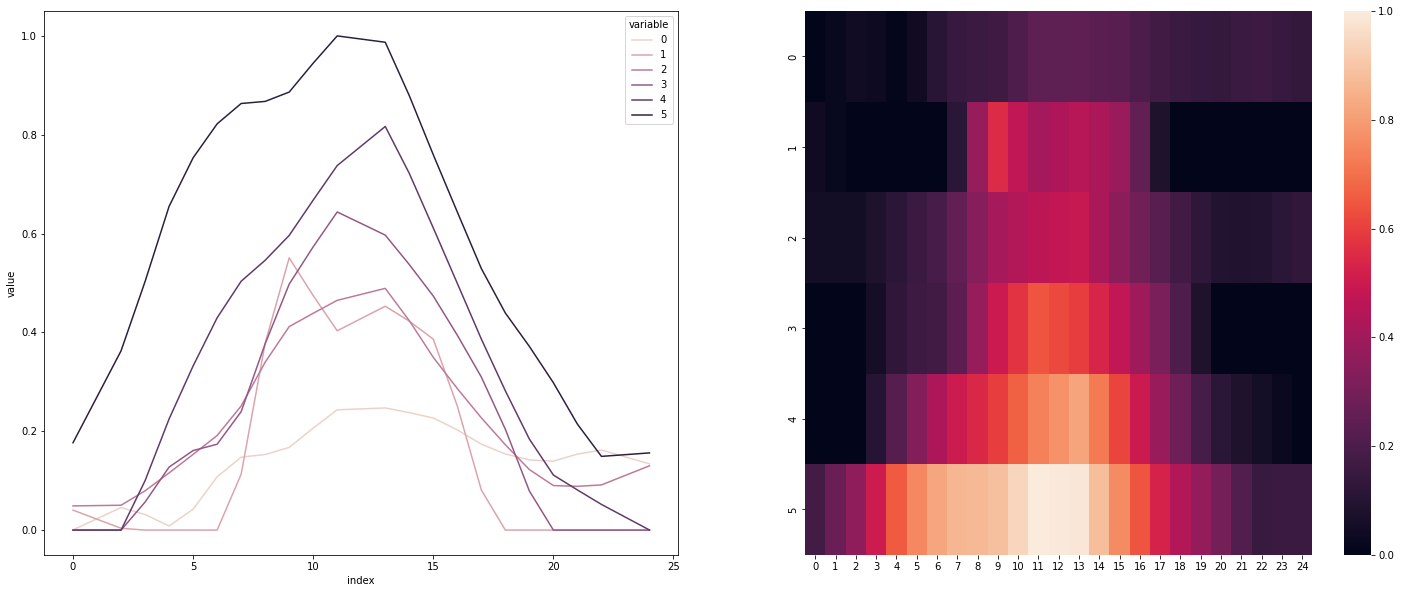

time: 468 ms (started: 2022-02-04 13:58:02 +01:00)


In [23]:
import matplotlib.pyplot as plt

fig, axs = plt.subplots(ncols=2)

sns.lineplot(
    data=melted_chroms,
    x="index",
    y="value",
    hue="variable",
    ax=axs[0]
)

axs[0].figure.set_size_inches(25, 10)

sns.heatmap(
    interpolated_chromatograms,
    ax=axs[1]
)